In [1]:
import torch
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
import os
import base64
from PIL import Image
import io
from dataProcessor import process_metadata, clean_text, correct_misinterpreted_characters, pew_metadata_path, statista_metadata_path, llava_description_path
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
import torch
import torch.nn.functional as F
from torch import Tensor

/home/mleshashi/thesis-sharma/sraEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path, llava_description_path)

# Apply text cleaning and correction functions
combined_df['title'] = combined_df['title'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['caption'] = combined_df['caption'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['llava_description'] = combined_df['llava_description'].apply(clean_text).apply(correct_misinterpreted_characters)

combined_df.shape

(29354, 5)

In [3]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img

In [4]:
# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the tokenizer and quantized model
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained(
    'intfloat/e5-mistral-7b-instruct',
    quantization_config=quantization_config,
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.09s/it]


In [5]:
# Correctly formatted URL for a local Elasticsearch instance
es = Elasticsearch(["http://localhost:9200"])

# define the index name
index_name = "documents"

In [6]:
# Ensure inputs are moved to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move the model to the appropriate device if needed
print(f"Model is on device: {next(model.parameters()).device}")

# Define the maximum length for the input text
max_length = 1250

Using device: cuda
Model is on device: cuda:0


In [7]:
# Function to perform last token pooling on hidden states based on the attention mask.
# It handles cases with left or right padding.
def last_token_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]
    
    
# Function to format a detailed instruction string from a task description and query.
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# Function to embed texts
def embed_texts(texts):
    input_token = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
    input_token = {k: v.to(device) for k, v in input_token.items()}
    with torch.no_grad():  # Ensure no gradients are calculated
        outputs = model(**input_token)
        embeddings = last_token_pool(outputs.last_hidden_state, input_token['attention_mask'])
        embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings.detach().cpu().numpy().flatten().tolist()

In [8]:
# Indexing the documents into embeddings using Elasticsearch with its unique ID, ensuring no duplicates are created.
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Concatenate title and caption with a space or some delimiter
    combined_text = f"{row['title']}. {row['caption']}"
    
    # Generate embedding for the combined text
    embedding = embed_texts(combined_text)

    # Generate a unique ID for the document using a hash of the title and caption
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Get Base64-encoded image data
    image_path = row['imgPath']
    base64_image_data = image_to_base64(image_path)
    
    # Index the document with the combined embedding, image data, and use the unique_id as the document ID
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "image_data": base64_image_data,
        "mistral_embedding": embedding
    })
    
    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Optional: Clear variables if no longer needed
    del combined_text, embedding, image_path, base64_image_data

100%|██████████| 29354/29354 [2:39:01<00:00,  3.08it/s]  


In [9]:
doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index: {doc_count}")

Number of documents in the index: 29348


In [10]:
# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Assuming initialization and index creation as before
topics_df = pd.read_csv('../dataset/topics.csv')

# Dictionary to hold total similarity scores for each topic
topic_similarity_scores = {}

for _, row in topics_df.iterrows():
    question = row['Topic']
    query = get_detailed_instruct(task, question)
    query_embedding = embed_texts(query)
    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'mistral_embedding') + 1.0",
                "params": {"query_vector": query_embedding}
            }
        }
    }
    
    response = es.search(index=index_name, body={
        "size": 50,  # You might want to adjust this size based on your needs
        "query": script_query,
        "_source": {"includes": ["title", "content", "image_data"]}  # Include the image data in the response
    })

    # Sum up the scores of all hits for this topic
    total_score = sum(hit['_score'] for hit in response['hits']['hits'])
    topic_similarity_scores[question] = total_score

    # Rank topics by their total similarity score
sorted_topics = sorted(topic_similarity_scores.items(), key=lambda x: x[1], reverse=True)

In [11]:
# Output the top 10 relevant topics
print("Top 10 Relevant Topics Based on Similarity Score:")
for i, (topic, score) in enumerate(sorted_topics[:30], 1):
    print(f"{i}. Topic: {topic}, Total Similarity Score: {score}")


Top 10 Relevant Topics Based on Similarity Score:
1. Topic: Should the government allow illegal immigrants to become citizens?, Total Similarity Score: 85.00669090000004
2. Topic: Is wind power the best alternative energy source?, Total Similarity Score: 84.99578509999999
3. Topic: Are social media platforms doing enough to prevent cyberbullying?, Total Similarity Score: 84.99369700000001
4. Topic: Is a college education worth it?, Total Similarity Score: 84.98672289999999
5. Topic: Are gas prices too high?, Total Similarity Score: 84.75740729999997
6. Topic: Should children have mobile phones?, Total Similarity Score: 84.51819870000003
7. Topic: Should abortion be legal?, Total Similarity Score: 84.47874850000001
8. Topic: Are social networking sites good for our society?, Total Similarity Score: 84.38411789999999
9. Topic: Should recreational marijuana be legal?, Total Similarity Score: 84.27471800000002
10. Topic: Does poverty cause crime?, Total Similarity Score: 84.07223889999997


In [12]:
# Create a DataFrame with the top relevant topics and their similarity scores
topics_df = pd.DataFrame(sorted_topics[:30], columns=['Topic', 'Similarity Score'])
# Specify the full path for saving the CSV file
csv_path = '../dataset/Touche4.csv'
# Save the DataFrame to the specified CSV file path
topics_df.to_csv(csv_path, index=False)

print("Top relevant topics saved to Touche.csv")

Top relevant topics saved to Touche.csv


***Retriving the top context from a random topic***

In [13]:
# Select a random topic
import random

topics_df = pd.read_csv('../dataset/TopRelevant_topics1.csv')   
#question = random.choice(topics_df['Topic'].to_list())

question= 'Are gas prices too high?'

# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Generate the detailed instruction string
query = get_detailed_instruct(task, question)
query_embedding = embed_texts(query)

# Define the script query for Elasticsearch
query

'Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery: Are gas prices too high?'

Top 3 relevant documents for the topic 'Are gas prices too high?':

1. Title: What Is the Main Reason Gas Price Has Gone Up Recently?
   Content: About three-in-ten (31%) offer a variation on this theme – greed, oil companies or speculation – when asked what they think is the main reason gasoline prices have gone up recently, according to a Pew Research Center/Washington Post survey conducted April 28-May 1 among 1,006 adults.  Roughly two-in-ten (19%) cite the ongoing wars or unrest in Libya and elsewhere in the Middle East as the top reason for rising fuel prices. Another 14% attribute this to politics or national policies.
   Score: 1.73732



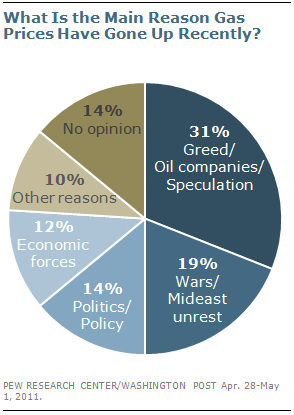

2. Title: Average annual U.S. gasoline prices during times of crisis between 1956 and 2011                                                     (in U.S. cents per gallon)
   Content: This statistic shows average annual U.S. gasoline prices in selected times of crisis between 1956 and 2011. In 1956, the year of the Suez crisis, the average annual gasoline price in the U.S. stood at 249.9 U.S. cents per gallon.
   Score: 1.7295141



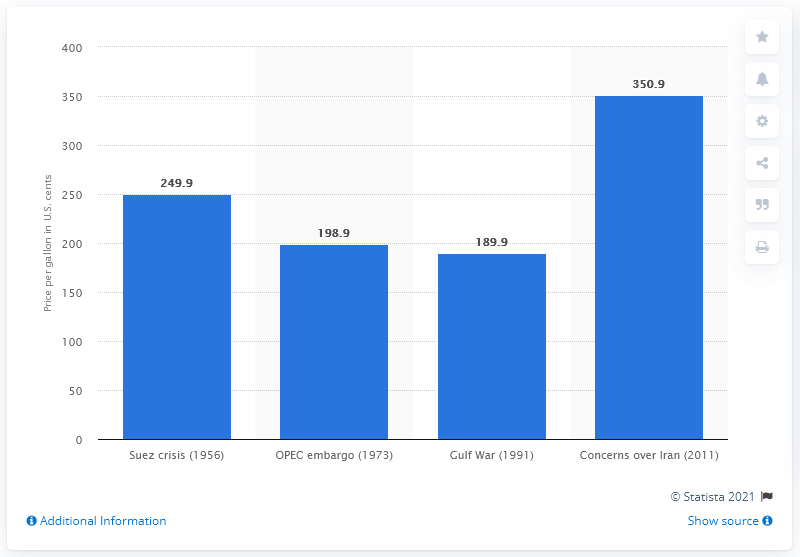

3. Title: Change in the price of gasoline per liter in selected countries from June 2019 to June 2020
   Content: This statistic shows the change in the price of gasoline per liter in selected countries for the period between June 2019 and June 2020. The price changes concern unleaded premium (95 RON) for France, Germany, Italy, Spain, and the United Kingdom, and regular unleaded for Canada, Japan, and the United States (AKI 87). RON stands for Research Octane Number, while AKI means Anti-Knock Index. Both represent the most common octane rating in the countries shown. In June 2020, the gasoline price per liter in the U.S. was 23.4 percent lower than it was in June 2019. Influences on gasoline prices The price of gasoline is a frequently discussed issue, and is a part of almost everybody’s life in developed countries. Gasoline prices worldwide are dependent of a number of factors: crude oil prices, costs for processing and distribution, demand, strength of currencies, taxation, and ava

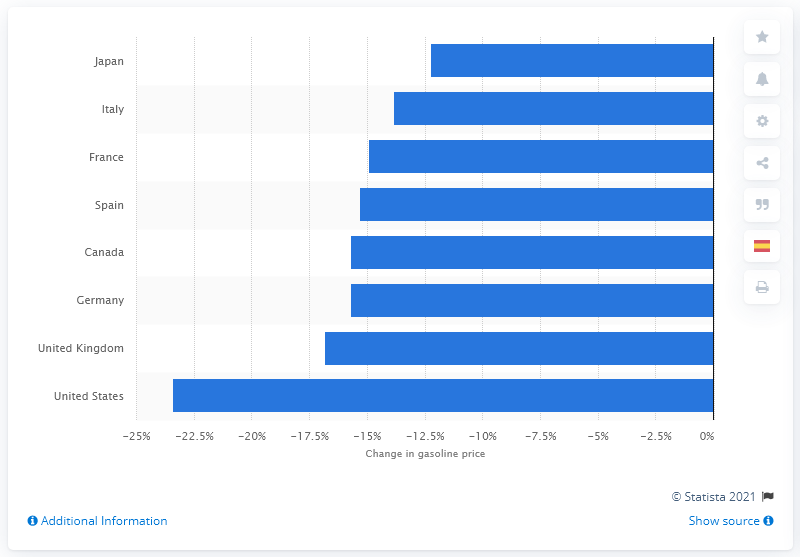

: 

In [14]:
# Elasticsearch query to find relevant documents based on cosine similarity
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'mistral_embedding') + 1.0",
            "params": {"query_vector": query_embedding}
        }
    }
}
    
# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{question}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data
    image_bytes = base64.b64decode(doc['image_data'])
    
    # Open the image from bytes
    image = Image.open(io.BytesIO(image_bytes))
    
    # Display the image
    image.show()

In [15]:
# Clear CUDA cache
torch.cuda.empty_cache()